# Creation of an Q-Env

Env definition by [tutorial](https://www.youtube.com/watch?v=G92TF4xYQcU).

Player (blue) searches for moving food (green) in environment, while doing so an enemy (red) is doing random moves.

on # 0, epsilon: 0.9
3000 ep mean nan


/home/phil/work/private/chess/ml/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/phil/work/private/chess/ml/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
QApplication: invalid style override 'kvantum' passed, ignoring it.
	Available styles: Windows, Fusion


on # 3000, epsilon: 0.49390083359356435
3000 ep mean -184.20066666666668
on # 6000, epsilon: 0.27104225936046566
3000 ep mean -148.18466666666666
on # 9000, epsilon: 0.14874221981913022
3000 ep mean -106.21733333333333
on # 12000, epsilon: 0.08162656262136181
3000 ep mean -74.193
on # 15000, epsilon: 0.044794919246742226
3000 ep mean -61.074333333333335
on # 18000, epsilon: 0.024582497729691496
3000 ep mean -47.980333333333334
on # 21000, epsilon: 0.01349035124500733
3000 ep mean -37.62733333333333
on # 24000, epsilon: 0.0074032174726434705
3000 ep mean -35.364333333333335


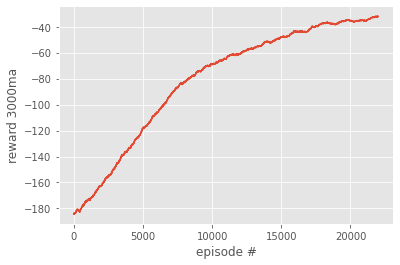

In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time

style.use('ggplot')


SIZE = 10
NUM_EPISODES = 25_000
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 25

epsilon = 0.9
EPS_DECAY = 0.9998

SHOW_EVERY = 3_000

start_q_table = None  # or filename

LEARNING_RATE = 0.1

DISCOUNT = 0.95

PLAYER_N = 1
FOOD_N = 2
ENEMY_N = 3

d = {
    PLAYER_N: (255, 175, 0),
    FOOD_N: (0, 255, 0),
    ENEMY_N: (0, 0, 255)
}

NUM_ACTIONS = 8

class Blob:
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)
        

    def __str__(self):
        return f'{self.x}, {self.y}'

    def __sub__(self, other):
        return (self.x- other.x, self.y-other.y)
    
    def action(self, choice):
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)
        # own code
        elif choice == 4:
            self.move(x=1, y=0)
        elif choice == 5:
            self.move(x=-1, y=0)
        elif choice == 6:
            self.move(x=0, y=1)
        elif choice == 7:
            self.move(x=0, y=-1)
        
    
    def move(self, x=False, y=False):
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y
        
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE - 1:
            self.x = SIZE - 1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE - 1:
            self.y = SIZE - 1

            
if start_q_table is None:
    q_table = dict()
    for x1 in range(-SIZE+1, SIZE):
        for y1 in range(-SIZE+1, SIZE):
            for x2 in range(-SIZE+1, SIZE):
                for y2 in range(-SIZE+1, SIZE):
                    q_table[((x1, y1), (x2, y2))] = [np.random.uniform(-5, 0) for i in range(NUM_ACTIONS)]
else:
    with open(start_q_table, 'rb') as f:
        q_table = pickle.load(f)

episode_rewards = list()

for episode in range(NUM_EPISODES):
    player = Blob()
    food = Blob()
    enemy = Blob()
    
    if episode % SHOW_EVERY == 0:
        print(f'on # {episode}, epsilon: {epsilon}')
        print(f'{SHOW_EVERY} ep mean {np.mean(episode_rewards[-SHOW_EVERY:])}')
        show = True
    else:
        show = False
    
    episode_reward = 0
    for i in range(200):
        obs = (player-food, player-enemy)
        
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, NUM_ACTIONS)
        
        player.action(action)
        
        
        #### maybe later 
        enemy.move()
        food.move()
        ################

        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
        
        new_obs = (player-food, player-enemy)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]
        
        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        elif reward == -ENEMY_PENALTY:
            new_q = -ENEMY_PENALTY
        else:
            new_q = (1-LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

        q_table[obs][action] = new_q
        
        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)
            env[food.y][food.x] = d[FOOD_N]
            env[player.y][player.x] = d[PLAYER_N]
            env[enemy.y][enemy.x] = d[ENEMY_N]
            
            img = Image.fromarray(env, "RGB")
            img = img.resize((300, 300))
            
            cv2.imshow("", np.array(img))
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        episode_reward += reward
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,)) / SHOW_EVERY, mode='valid')
plt.plot([i for i in range((len(moving_avg)))], moving_avg)
plt.ylabel(f'reward {SHOW_EVERY}ma')
plt.xlabel('episode #')
plt.show()

with open(f'qtable-{int(time.time())}.pickle', 'wb') as f:
    pickle.dump(q_table, f)
